In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from streamlit_folium import folium_static
import hdbscan
import folium
from sklearn.preprocessing import StandardScaler
from haversine import haversine
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import (
    mean_squared_error,
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix,
    precision_score, recall_score, f1_score
)
from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def plot_clusters_on_map(df):
    """Визуализация кластеров на карте"""
    m = folium.Map(location=[55.0, 82.9], zoom_start=12)

    # Цвета для кластеров
    from folium.plugins import MarkerCluster

    # Создаем слой для каждого кластера
    for cluster_id in df['geo_cluster'].unique():
        if cluster_id == -2:  # пропуски (нулевые координаты)
            continue
        cluster_data = df[df['geo_cluster'] == cluster_id]
        color = 'red' if cluster_id == -1 else 'blue'  # -1 = шум в HDBSCAN

        # Добавляем среднюю точку кластера
        folium.Marker(
            location=[cluster_data['lat'].mean(), cluster_data['lon'].mean()],
            popup=f"Кластер {cluster_id}, {len(cluster_data)} записей",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(m)

        # Добавляем точки
        for _, row in cluster_data.head(1000).iterrows():  # ограничение для производительности
            folium.CircleMarker(
                location=[row['lat'], row['lon']],
                radius=3 if cluster_id != -1 else 5,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=0.7
            ).add_to(m)

    return m


def deg_to_rad(X):
    """Переводит градусы в радианы"""
    return np.radians(X)


def add_hdbscan_clusters(df):
    """
    Добавляет кластеры геолокаций с помощью HDBSCAN
    """
    # Проверка наличия координат
    if 'lat' not in df.columns or 'lon' not in df.columns:
        raise ValueError("В датафрейме должны быть колонки 'lat' и 'lon'")

    # Фильтр точек с нулевыми координатами (если нужно обработать отдельно)
    zero_coords_mask = (df['lat'] == 0) & (df['lon'] == 0)
    valid_coords_df = df[~zero_coords_mask]

    # Переводим координаты в радианы (требование HDBSCAN с метрикой haversine)
    coords = valid_coords_df[['lat', 'lon']].values
    coords_rad = deg_to_rad(coords)

    # Настройка HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=10,  # минимальный размер кластера
        min_samples=5,  # количество соседей для точки
        metric='haversine',  # метрика Хаверсина для геокоординат
        core_dist_n_jobs=-1  # использовать все ядра
    )

    # Предсказание кластеров
    valid_coords_df.loc[:, 'geo_cluster'] = clusterer.fit_predict(coords_rad)

    # Восстанавливаем кластеры для всех данных (включая нулевые координаты)
    df['geo_cluster'] = -2  # -2 = не обработано (например, нулевые координаты)
    df.update(valid_coords_df[['geo_cluster']])

    return df


def load_and_preprocess_data(filepath):
    """Загрузка и предварительная обработка данных"""
    df = pd.read_csv(filepath, parse_dates=['receiveddatetime'])

    # Базовая обработка
    df['busnumber'] = df['busnumber'].fillna('UNKNOWN')
    for col in ['transactiontime', 'tarifficationdatetime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    df['has_coords'] = ((df['lat'] != 0) | (df['lon'] != 0)).astype(int)
    df['carduid'] = df['carduid'].astype(str).str.strip()
    df['terminalid'] = df['terminalid'].astype(str).str.strip()

    return df


def add_geo_features(df):
    """Добавление гео-признаков"""

    def calculate_distance(row, prev_row):
        if prev_row is None or row['carduid'] != prev_row['carduid']:
            return 0
        current_loc = (row['lat'], row['lon'])
        prev_loc = (prev_row['lat'], prev_row['lon'])
        return haversine(current_loc, prev_loc)

    # Сортировка и сброс индекса
    df = df.sort_values(by='receiveddatetime').reset_index(drop=True)

    # Расчет расстояний
    df['distance_prev'] = 0.0
    prev_row = None
    for i, row in df.iterrows():
        if prev_row is not None and row['carduid'] == prev_row['carduid']:
            df.at[i, 'distance_prev'] = calculate_distance(row, prev_row)
        prev_row = row

    # Расчет скорости
    df['time_diff_prev_hours'] = df['time_diff_prev'] / 3600
    df['speed_kmh'] = df['distance_prev'] / df['time_diff_prev_hours'].replace([np.inf, -np.inf], np.nan).fillna(0)

    df['speed_kmh'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['speed_kmh'].fillna(0, inplace=True)  # или другой метод заполнения
    # Кластеризация геолокаций
    df = add_hdbscan_clusters(df)

    return df


def create_rolling_features(df, windows=[1, 5, 10, 20, 30, 40, 50, 60, 120, 180, 240, 480, 720, 1440]):
    """Создание rolling-признаков"""

    def rolling_counts_for_group(group):
        group = group.sort_values(by='receiveddatetime')
        timestamps = group['receiveddatetime'].astype(np.int64) // 1_000_000_000

        result_data = {f'count_{w}m': np.zeros(len(group), dtype=np.int32) for w in windows}
        time_diff_prev = np.zeros(len(group), dtype=np.float32)
        start_idx_by_window = [0] * len(windows)

        prev_time = None
        for i in range(len(group)):
            current_time = timestamps.iloc[i]

            # Вычисляем time_diff_prev
            if i == 0:
                time_diff_prev[i] = 0
            else:
                time_diff_prev[i] = current_time - prev_time

            prev_time = current_time

            # Обработка всех окон
            for w_i, w in enumerate(windows):
                window_seconds = w * 60

                while (current_time - timestamps.iloc[start_idx_by_window[w_i]]) > window_seconds:
                    start_idx_by_window[w_i] += 1

                count_in_window = i - start_idx_by_window[w_i] + 1

                for j in range(start_idx_by_window[w_i], i + 1):
                    if result_data[f'count_{w}m'][j] < count_in_window:
                        result_data[f'count_{w}m'][j] = count_in_window

        # Создаем результат
        group_result = pd.DataFrame(index=group.index)
        group_result['temp_id'] = group['temp_id']

        for k, arr in result_data.items():
            group_result[k] = arr
        group_result['time_diff_prev'] = time_diff_prev

        return group_result

    # Подготовка данных для группировки
    df['temp_id'] = df.index
    results = []

    # Применяем rolling-функции
    for (card, term), g in df.groupby(['carduid', 'terminalid'], group_keys=False):
        feats = rolling_counts_for_group(g)
        results.append(feats)

    # Объединение результатов
    rolling_features = pd.concat(results, axis=0)
    rolling_features.set_index('temp_id', inplace=True)
    df = df.set_index('temp_id').join(rolling_features, rsuffix='_roll').reset_index(drop=True)

    return df


def build_autoencoder(input_dim):
    """Создание автоэнкодера"""

    class AnomalyDetector(Model):
        def __init__(self, input_dim):
            super(AnomalyDetector, self).__init__()
            self.encoder = tf.keras.Sequential([
                layers.Dense(16, activation='relu', input_shape=(input_dim,)),
                layers.Dense(8, activation='relu'),
                layers.Dense(4, activation='relu')
            ])
            self.decoder = tf.keras.Sequential([
                layers.Dense(8, activation='relu'),
                layers.Dense(16, activation='relu'),
                layers.Dense(input_dim, activation='linear')
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    return AnomalyDetector(input_dim)


def detect_anomalies(df, feature_cols):
    """Обнаружение аномалий с защитой от inf и больших значений"""
    # Добавляем дату
    df['date'] = df['receiveddatetime'].dt.date
    cutoff_date = pd.to_datetime("2025-03-21")

    # Разделение на train/test
    df_train = df[df['receiveddatetime'] < cutoff_date]
    df_test = df[df['receiveddatetime'] >= cutoff_date]

    # Проверка и очистка данных
    print("Проверка на inf и NaN в feature_cols:")
    print(np.isinf(df_train[feature_cols]).sum())
    print(df_train[feature_cols].isnull().sum())

    # Замена inf и NaN на 0
    X_train = df_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
    X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values

    # Ограничение максимальных значений (например, скорость > 1000 км/ч — редкость)
    X_train = np.clip(X_train, a_min=None, a_max=1e6)
    X_test = np.clip(X_test, a_min=None, a_max=1e6)

    # Нормализация
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Создание и обучение модели
    model = build_autoencoder(X_train_scaled.shape[1])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train_scaled, X_train_scaled,
        epochs=50,
        batch_size=512,
        validation_data=(X_test_scaled, X_test_scaled),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    # после history:
    X_test_recon = model.predict(X_test_scaled)
    mse = np.mean((X_test_scaled - X_test_recon)**2, axis=1)
    threshold = np.quantile(mse, 0.995)

    df_test = df_test.copy()
    df_test['anomaly_score'] = mse
    df_test['is_anomaly'] = mse > threshold
    df_test['threshold'] = threshold

    return df_test, model, scaler, history  # <<< добавили history

def plot_training_curves(history):
    """График loss/val_loss по эпохам"""
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.title('Кривые обучения автоэнкодера')
    plt.ylim(0, max(history.history['loss'] + history.history['val_loss']) * 1.1)
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.show()

def plot_error_distribution(df_test):
    """Гистограмма и CDF ошибок реконструкции"""
    errors = df_test['anomaly_score']
    p99_9 = np.quantile(errors, 0.999)
    errors_trunc = errors.clip(upper=p99_9)

    plt.figure(figsize=(8,5))
    plt.hist(errors_trunc, bins=100, density=True, alpha=0.6, label='All (<=99.9%)')
    # CDF на том же урезанном диапазоне
    sorted_e = np.sort(errors_trunc)
    cdf = np.arange(len(sorted_e)) / len(sorted_e)
    ax2 = plt.gca().twinx()
    ax2.plot(sorted_e, cdf, color='black', linestyle='--', label='CDF')
    plt.xscale('log')               # либо лог-шкала
    plt.xlabel('Ошибка реконструкции (MSE)')
    plt.ylabel('Плотность / CDF')
    plt.title('Распределение ошибок и CDF (лог‐шкала)')
    plt.legend(loc='upper left')
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.show()

def plot_roc_pr(df_test):
    """ROC- и PR-кривые, AUC"""
    # берём именно «правильные» метки
    y_true = df_test['is_anomaly'].astype(int)
    # а в качестве score — ту же «аномальность» от автоэнкодера
    scores = df_test['anomaly_score']

    # ROC
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-кривая')
    plt.legend()
    plt.grid(True, ls='--', lw=0.5)
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall кривая')
    plt.legend()
    plt.grid(True, ls='--', lw=0.5)
    plt.show()

def print_confusion_table(df_test, thresholds=[None]):
    """Матрицы ошибок и метрики для списка порогов.
       thresholds=None означает порог из данных (quantile 0.995)"""
    y_true = df_test['is_anomaly'].astype(int)
    scores = df_test['anomaly_score']
    base_thr = df_test['threshold'].iloc[0]
    for thr in thresholds:
        thr_val = base_thr if thr is None else thr
        y_pred = (scores > thr_val).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        print(f"\nПорог = {thr_val:.3f}")
        print("Confusion matrix:\n", cm)
        print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

def plot_tsne_latent(model, scaler, X_test_scaled, df_test):
    """t-SNE от кодов автоэнкодера"""
    # достаём encoder
    encoder = model.encoder
    # получаем латентные векторы
    latent = encoder.predict(X_test_scaled)
    tsne = TSNE(n_components=2, random_state=42)
    z = tsne.fit_transform(latent)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=z[:,0], y=z[:,1], hue=df_test['is_anomaly'], palette=['green','red'], alpha=0.6)
    plt.title('t-SNE латентного пространства (0 – норма, 1 – аномалия)')
    plt.show()


In [2]:
# === Основной пайплайн ===
if __name__ == "__main__":
    # 1. Загрузка и предварительная обработка
    df = load_and_preprocess_data(r'D:\University\Diplom\FINAL\transactions.csv')

    # 2. Создание rolling-фичей
    df = create_rolling_features(df)

    # 3. Добавление гео-фичей
    df = add_geo_features(df)

C:\Users\grias\AppData\Local\Temp\ipykernel_22424\2157429517.py:141: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['speed_kmh'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\grias\AppData\Local\Temp\ipykernel_22424\2157429517.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [11]:
    # 4. Определение фичей для модели
    base_features = [
        'count_1m',
        'count_5m',
        'count_10m',
        'count_20m',
        'count_30m',
        'count_40m',
        'count_50m',
        'count_60m',
        'count_120m',
        'count_180m',
        'count_240m',
        'count_480m',
        'count_720m',
        'count_1440m',
        'time_diff_prev', 'finalticketprice', 'baseticketprice', 'ticketscount'
    ]

    geo_features = ['distance_prev', 'speed_kmh', 'has_coords', 'geo_cluster']

    feature_cols = base_features + geo_features
    print(f"Используемые признаки ({len(feature_cols)}):", feature_cols)

    # 5. Обнаружение аномалий
    df_test, model, scaler, history = detect_anomalies(df, feature_cols)

Используемые признаки (22): ['count_1m', 'count_5m', 'count_10m', 'count_20m', 'count_30m', 'count_40m', 'count_50m', 'count_60m', 'count_120m', 'count_180m', 'count_240m', 'count_480m', 'count_720m', 'count_1440m', 'time_diff_prev', 'finalticketprice', 'baseticketprice', 'ticketscount', 'distance_prev', 'speed_kmh', 'has_coords', 'geo_cluster']
Проверка на inf и NaN в feature_cols:
count_1m            0
count_5m            0
count_10m           0
count_20m           0
count_30m           0
count_40m           0
count_50m           0
count_60m           0
count_120m          0
count_180m          0
count_240m          0
count_480m          0
count_720m          0
count_1440m         0
time_diff_prev      0
finalticketprice    0
baseticketprice     0
ticketscount        0
distance_prev       0
speed_kmh           0
has_coords          0
geo_cluster         0
dtype: int64
count_1m            0
count_5m            0
count_10m           0
count_20m           0
count_30m           0
count_4

D:\University\Diplom\.venv1\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 2s 892us/step - loss: 0.5816 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 2/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 0.2393 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 3/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - loss: 0.1261 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 4/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.0785 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 5/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.1031 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 6/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step - loss: 0.0900 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 7/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.1786 - val_loss: 0.0911 - learning_rate: 0.0010
Epoch 8/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.1062 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 9/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - loss: 0.1598 - val_loss: 0.0708 - learnin

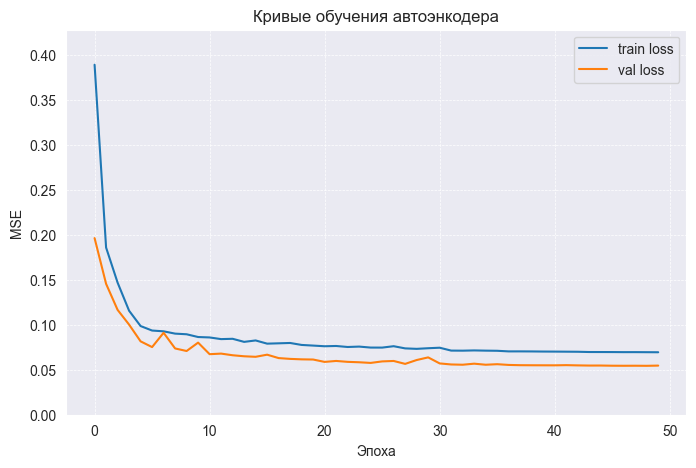

D:\University\Diplom\.venv1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


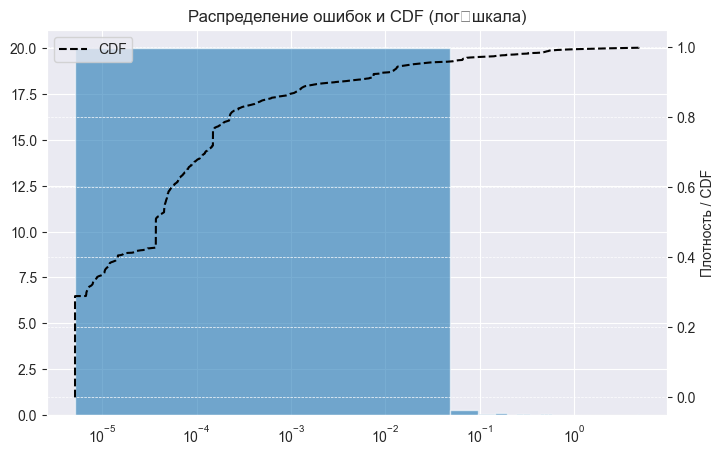

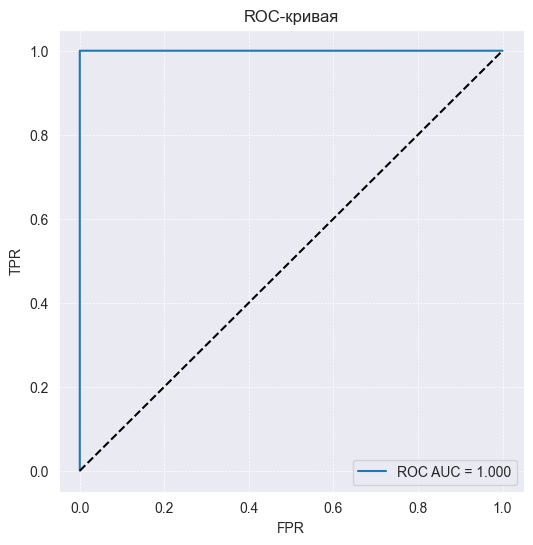

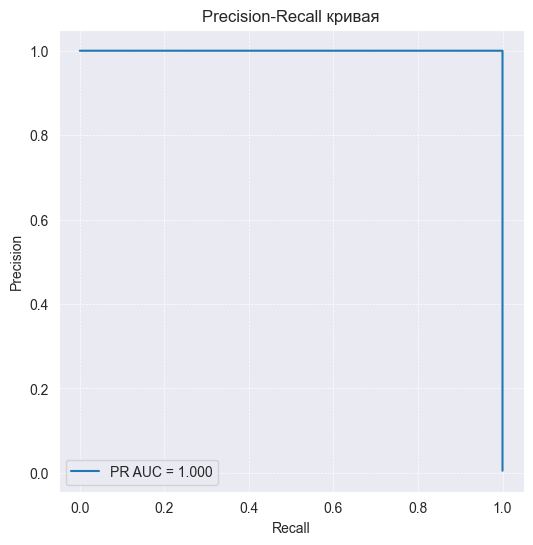


Порог = 1.048
Confusion matrix:
 [[223414      0]
 [     0   1123]]
Precision: 1.000, Recall: 1.000, F1: 1.000

Порог = 0.943
Confusion matrix:
 [[223309    105]
 [     0   1123]]
Precision: 0.914, Recall: 1.000, F1: 0.955

Порог = 1.153
Confusion matrix:
 [[223414      0]
 [    57   1066]]
Precision: 1.000, Recall: 0.949, F1: 0.974
7017/7017 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step


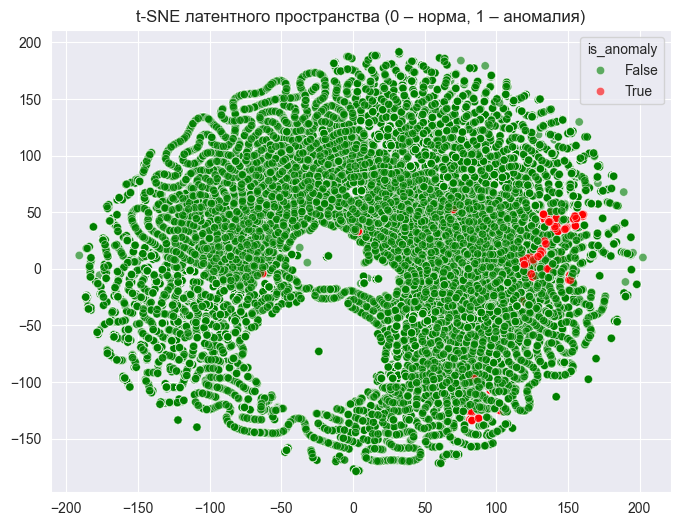

KeyError: 'true_label'

In [16]:


    # === CHAPTER 3: вызов новых функций ===
    plot_training_curves(history)
    plot_error_distribution(df_test)
    plot_roc_pr(df_test)
    print_confusion_table(df_test,
                          thresholds=[None, df_test['threshold'].iloc[0] * 0.9, df_test['threshold'].iloc[0] * 1.1])

    # Для t-SNE нужна матрица X_test_scaled — вернём её из detect_anomalies
    # Либо повторно подготовить:
    X_test = df_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
    X_test_scaled = scaler.transform(X_test)
    plot_tsne_latent(model, scaler, X_test_scaled, df_test)



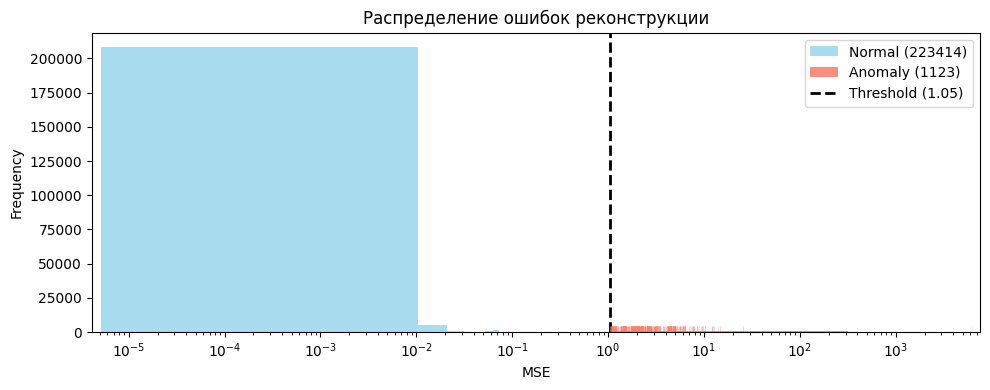

<Figure size 640x480 with 0 Axes>

График сохранён в error_distribution.png


In [37]:
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
    # 6. Визуализация и сохранение
    norm_errors = df_test.loc[df_test['is_anomaly']==0, 'anomaly_score']
    anom_errors = df_test.loc[df_test['is_anomaly']==1, 'anomaly_score']

    # Получаем порог
    thr = np.quantile(df_test['anomaly_score'], 0.995)
    norm_errors = df_test['anomaly_score'][df_test['anomaly_score'] <= thr]
    anom_errors = df_test['anomaly_score'][df_test['anomaly_score'] >  thr]

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.hist(norm_errors, bins=100, alpha=0.7, color='skyblue',
            label=f'Normal ({len(norm_errors)})')
    ax.hist(anom_errors, bins=20,  alpha=0.9, color='salmon',
            label=f'Anomaly ({len(anom_errors)})')
    ax.axvline(thr, color='k', linestyle='--', linewidth=2,
               label=f'Threshold ({thr:.2f})')

    ax.set_xscale('log')
    ax.set_xlim(norm_errors.min()*0.8, max(anom_errors.max()*1.2, thr*10))
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency')        # единственный y-label
    ax.set_title('Распределение ошибок реконструкции')
    ax.legend(loc='upper right')
    # ax.grid(True, which='both', ls='--', lw=0.5)

    # Rug-plot мелких штрихов у основания
    ax.vlines(anom_errors, ymin=0, ymax=ax.get_ylim()[1]*0.02,
              color='salmon', alpha=0.3, linewidth=0.5)

    # Inset для низких MSE без лишних штрихов по y
    # axins = inset_axes(ax, width="30%", height="50%", loc='upper left')
    # max_small = np.quantile(norm_errors, 0.999)
    # axins.hist(norm_errors.clip(upper=max_small), bins=50,
    #            alpha=0.7, color='skyblue')
    # axins.hist(anom_errors.clip(upper=max_small), bins=10,
    #            alpha=0.9, color='salmon')
    # axins.axvline(thr, color='k', linestyle='--', linewidth=1)
    # axins.set_xlim(0, max_small)
    # axins.set_xscale('linear')
    # axins.set_xlabel('MSE', fontsize='small')
    # axins.set_yticks([])               # у inset убираем y-метки
    # axins.set_title('Низкие MSE', fontsize='small')
    # axins.grid(True, which='both', ls='--', lw=0.3)

    # Убираем соединительные линии, просто раскомментируйте следующую строку, если нужны тонкие штрихи:
    # mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle='--')

    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    fig.savefig('error_distribution.png', dpi=150)
    plt.show()
    print("График сохранён в error_distribution.png")

In [41]:
    train_final_mse = history.history['loss'][-1]
    test_mean_mse   = df_test['anomaly_score'].mean()
    recon_error_ratio = test_mean_mse / train_final_mse
    print(f"Reconstruction Error Ratio (test/train): {recon_error_ratio:.2f}")

    errors = df_test['anomaly_score']
    thr = np.quantile(errors, 0.995)
    delta = thr * 0.01  # 1% от порога
    cdf = lambda x: (errors <= x).mean()
    slope = (cdf(thr + delta) - cdf(thr - delta)) / (2 * delta)
    print(f"Slope of CDF near threshold: {slope:.3f}")

    def jaccard(a, b): return len(a & b) / len(a | b)

    idx0 = set(df_test[errors > thr].index)
    thr_lo = np.quantile(errors, 0.992)
    thr_hi = np.quantile(errors, 0.998)
    idx_lo = set(df_test[errors > thr_lo].index)
    idx_hi = set(df_test[errors > thr_hi].index)

    print("Jaccard 0.995 vs 0.992:", jaccard(idx0, idx_lo))
    print("Jaccard 0.995 vs 0.998:", jaccard(idx0, idx_hi))

    from sklearn.metrics import silhouette_score
    encoder = model.encoder

    # теперь можно получить латентные векторы
    latent = encoder.predict(X_test_scaled)
    labels = (df_test['anomaly_score'] > thr).astype(int)
    sil_score = silhouette_score(latent, labels)
    print(f"Silhouette score on latent space: {sil_score:.3f}")

Reconstruction Error Ratio (test/train): 0.78
Slope of CDF near threshold: 0.001
Jaccard 0.995 vs 0.992: 0.6249304396215916
Jaccard 0.995 vs 0.998: 0.40071237756010686
7017/7017 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step
Silhouette score on latent space: 0.900


In [ ]:
    # Визуализация
    m = plot_clusters_on_map(df)
    folium_static(m)

    # Сохранение аномалий
    anomalies = df_test[df_test['is_anomaly']]
    anomalies.to_csv("detected_anomalies.csv", index=False)

    # Сохранение модели
    model.save('transaction_anomaly_detector_geo.h5')